Simulations were made with: 150 FF motoneurons, 75 FR motoneurons, 75 S motoneurons and 300 Renshaw cells. All motoneurons were stimulated for 3.5 s at the same rate by asynchronous descending command inputs and in successive trials, the mean rates of the descending command signals inputs were 10, 20, 30,. . ., 400 pps (Uchiyama et al. 2003).

In [234]:
import sys
sys.path.insert(0, '..')
# Allows plots to be zoomed in, etc
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

from Configuration import Configuration
from MotorUnitPool import MotorUnitPool
from InterneuronPool import InterneuronPool
from NeuralTract import NeuralTract
from SynapsesFactory import SynapsesFactory

In order to obtain the mean firing rate of a single S-type MN, for example, the number of spikes discharged from 0.5 s to 3.5 s was divided by 3 s. The ensemble average of the rates of all S-type MNs (including the zero rates of nonactive MNs) was then calculated as the mean of the individual rates (Uchiyama et al. 2003).

In [235]:
def simulation_old(driveFunction):
    conf = Configuration('confuchiyama.rmto')

    # Number of cells
    idx = np.where(conf.confArray['f0']=='MUnumber_SOL-S')[0][0]
    conf.confArray['f1'][idx] = 1
    idx = np.where(conf.confArray['f0']=='MUnumber_SOL-FR')[0][0]
    conf.confArray['f1'][idx] = 1
    idx = np.where(conf.confArray['f0']=='MUnumber_SOL-FF')[0][0]
    conf.confArray['f1'][idx] = 2
    idx = np.where(conf.confArray['f0']=='Number_RC_ext')[0][0]
    conf.confArray['f1'][idx] = 4
    idx = np.where(conf.confArray['f0']=='Number_CMExt')[0][0]
    conf.confArray['f1'][idx] = 600

    # Duration of simulation
    conf.simDuration_ms = 1000
    
    # Generate firing rate with ISI varying according to a gaussian ditribution
    idx = np.where(conf.confArray['f0']=='GammaOrder_CMExt')[0][0]
    conf.confArray['f1'][idx] = 10
    idx = np.where(conf.confArray['f0']=='DriveTarget_CMExt')[0][0]
    conf.confArray['f1'][idx] = 'FR'
    idx = np.where(conf.confArray['f0']=='DriveFunction_CMExt')[0][0]
    conf.confArray['f1'][idx] = driveFunction

    # Connectivity changes
    #idx = np.where(conf.confArray['f0']=='Con:CMExt->SOL-S@dendrite|excitatory')[0][0]
    #conf.confArray['f1'][idx] = 100

    # Parameters from java
    ## Connectivity
    idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-S@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 100
    idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-FR@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 100
    idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-FF@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 100
    idx = np.where(conf.confArray['f0']=='Con:SOL-S>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 100
    idx = np.where(conf.confArray['f0']=='Con:SOL-FR>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 100
    idx = np.where(conf.confArray['f0']=='Con:SOL-FF>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 100

    ## Conductances
    idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-S@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 0.44
    idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-FR@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 0.3
    idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-FF@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 0.24
    idx = np.where(conf.confArray['f0']=='gmax:SOL-S>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 0.15
    idx = np.where(conf.confArray['f0']=='gmax:SOL-FR>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 0.17
    idx = np.where(conf.confArray['f0']=='gmax:SOL-FF>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 0.3

    ## Morphology
    idx = np.where(conf.confArray['f0']=='d@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 65
    conf.confArray['f2'][idx] = 65
    idx = np.where(conf.confArray['f0']=='l@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 285
    conf.confArray['f2'][idx] = 285
    idx = np.where(conf.confArray['f0']=='res@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 200
    conf.confArray['f2'][idx] = 200
    
    pools = dict()
    pools[0] = MotorUnitPool(conf, 'SOL')
    pools[1] = InterneuronPool(conf, 'RC', 'ext')
    pools[2] = NeuralTract(conf, 'CMExt')

    Syn = SynapsesFactory(conf, pools)

    t = np.arange(0.0, conf.simDuration_ms, conf.timeStep_ms)

    for i in xrange(0, len(t)):
        pools[2].atualizePool(t[i]) # Neural tract
        pools[0].atualizeMotorUnitPool(t[i]) # MN pool
        pools[3].atualizePool(t[i]) # RC synaptic Noise
        pools[1].atualizeInterneuronPool(t[i]) # RC pool

    pools[0].listSpikes()
    pools[1].listSpikes()
    pools[2].listSpikes()
    
    # Spikes recorded in a steady state interval, herein considered to be >500 ms
    tmin = 500
    firingRates = []
    for i in xrange(pools[0].MUnumber):
        MUactivity = pools[0].poolTerminalSpikes[pools[0].poolTerminalSpikes[:,1]==i, 0]
        numberOfSpikes = len(MUactivity[MUactivity>tmin])
        firingRates.append(float(numberOfSpikes)/(conf.simDuration_ms-tmin)) # force division to floating point
    
    return firingRates

In [236]:
def simulation_new(driveFunction):
    conf = Configuration('confuchiyama.rmto')

    # Number of cells
    idx = np.where(conf.confArray['f0']=='MUnumber_SOL-S')[0][0]
    conf.confArray['f1'][idx] = 1
    idx = np.where(conf.confArray['f0']=='MUnumber_SOL-FR')[0][0]
    conf.confArray['f1'][idx] = 1
    idx = np.where(conf.confArray['f0']=='MUnumber_SOL-FF')[0][0]
    conf.confArray['f1'][idx] = 2
    idx = np.where(conf.confArray['f0']=='Number_RC_ext')[0][0]
    conf.confArray['f1'][idx] = 4
    idx = np.where(conf.confArray['f0']=='Number_CMExt')[0][0]
    conf.confArray['f1'][idx] = 600

    # Duration of simulation
    conf.simDuration_ms = 1000
    
    # Generate firing rate with ISI varying according to a gaussian ditribution
    idx = np.where(conf.confArray['f0']=='GammaOrder_CMExt')[0][0]
    conf.confArray['f1'][idx] = 10
    idx = np.where(conf.confArray['f0']=='DriveTarget_CMExt')[0][0]
    conf.confArray['f1'][idx] = 'FR'
    idx = np.where(conf.confArray['f0']=='DriveFunction_CMExt')[0][0]
    conf.confArray['f1'][idx] = driveFunction

    # Connectivity changes
    #idx = np.where(conf.confArray['f0']=='Con:CMExt->SOL-S@dendrite|excitatory')[0][0]
    #conf.confArray['f1'][idx] = 100

    # Parameters from Python
    ## Connectivity
    idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-S@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 4
    idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-FR@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 4
    idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-FF@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 4
    idx = np.where(conf.confArray['f0']=='Con:SOL-S>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 6
    idx = np.where(conf.confArray['f0']=='Con:SOL-FR>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 6
    idx = np.where(conf.confArray['f0']=='Con:SOL-FF>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 6

    ## Conductances
    idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-S@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 0.44
    idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-FR@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 0.44
    idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-FF@soma|inhibitory')[0][0]
    conf.confArray['f1'][idx] = 0.44
    idx = np.where(conf.confArray['f0']=='gmax:SOL-S>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 0.15
    idx = np.where(conf.confArray['f0']=='gmax:SOL-FR>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 0.15
    idx = np.where(conf.confArray['f0']=='gmax:SOL-FF>RC_ext-@soma|excitatory')[0][0]
    conf.confArray['f1'][idx] = 0.15

    ## Morphology
    idx = np.where(conf.confArray['f0']=='d@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 25
    conf.confArray['f2'][idx] = 25
    idx = np.where(conf.confArray['f0']=='l@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 242
    conf.confArray['f2'][idx] = 242
    idx = np.where(conf.confArray['f0']=='res@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 760
    conf.confArray['f2'][idx] = 760
    
    pools = dict()
    pools[0] = MotorUnitPool(conf, 'SOL')
    pools[1] = InterneuronPool(conf, 'RC', 'ext')
    pools[2] = NeuralTract(conf, 'CMExt')

    Syn = SynapsesFactory(conf, pools)

    t = np.arange(0.0, conf.simDuration_ms, conf.timeStep_ms)

    for i in xrange(0, len(t)):
        pools[2].atualizePool(t[i]) # Neural tract
        pools[0].atualizeMotorUnitPool(t[i]) # MN pool
        pools[3].atualizePool(t[i]) # RC synaptic Noise
        pools[1].atualizeInterneuronPool(t[i]) # RC pool

    pools[0].listSpikes()
    pools[1].listSpikes()
    pools[2].listSpikes()

    # Spikes recorded in a steady state interval, herein considered to be >500 ms
    tmin = 500
    firingRates = []
    for i in xrange(pools[0].MUnumber):
        MUactivity = pools[0].poolTerminalSpikes[pools[0].poolTerminalSpikes[:,1]==i, 0]
        numberOfSpikes = len(MUactivity[MUactivity>tmin])
        firingRates.append(float(numberOfSpikes)/(conf.simDuration_ms-tmin)) # force division to floating point
    
    return firingRates

Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 712 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 757 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 742 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 728 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC e

Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 742 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 715 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 749 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 750 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC e

<IPython.core.display.Javascript object>


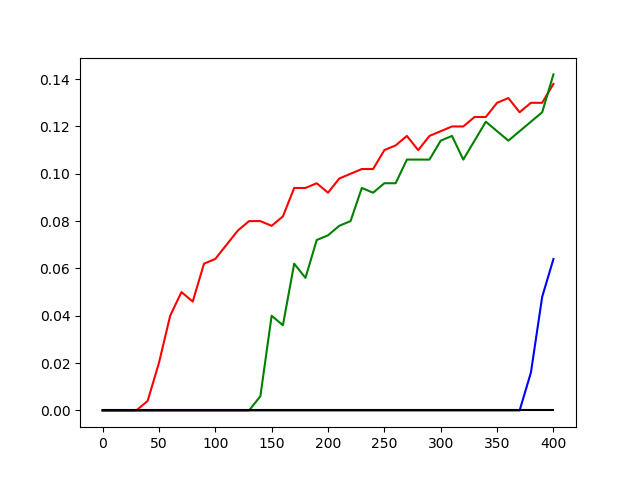

In [237]:
pps = range(0, 410, 10)
ratesOnTrial = []
for i in pps:
    ratesOnTrial.append(simulation_old(str(i)+'+0*t'))

S = [item[0] for item in ratesOnTrial]
FR = [item[1] for item in ratesOnTrial]
FF1 = [item[2] for item in ratesOnTrial]
FF2 = [item[3] for item in ratesOnTrial]

plt.figure()
plt.plot(pps, S, 'r')
plt.plot(pps, FR, 'g')
plt.plot(pps, FF1, 'b')
plt.plot(pps, FF2, 'k')
plt.show()

Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 698 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 745 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 737 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 722 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC e

Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 707 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 684 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 738 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
Descending Command CMExt built
All the 723 synapses were built
Synaptic Noise on RC_ext built
All the 4 synaptic noises were built
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC e

<IPython.core.display.Javascript object>


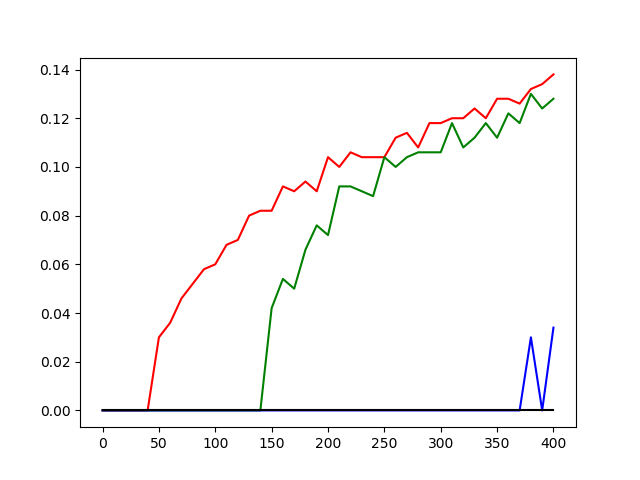

In [238]:
ratesOnTrial = []
for i in pps:
    ratesOnTrial.append(simulation_new(str(i)+'+0*t'))

S = [item[0] for item in ratesOnTrial]
FR = [item[1] for item in ratesOnTrial]
FF1 = [item[2] for item in ratesOnTrial]
FF2 = [item[3] for item in ratesOnTrial]

plt.figure()
plt.plot(pps, S, 'r')
plt.plot(pps, FR, 'g')
plt.plot(pps, FF1, 'b')
plt.plot(pps, FF2, 'k')
plt.show()

In [ ]:
# For avarage of the population
#avgRate = [float(sum(col))/len(col) for col in zip(*ratesOnTrial)]

As discussed in Duchateau and Baudry (2014), maximal discharge rate during slow isometric ramp contractions usually reaches values of 20–50 Hz whereas it can attain much higher values (>100 Hz), albeit briefly, during fast contractions (for reviews, see Enoka and Fuglevand, 2001; Duchateau and Enoka, 2011). Therefore, pps values used above are not realistic, but are used to evaluate MNs behavior.